In [33]:
import numpy as np
import os

from keras.optimizers import Adam
from utils.facades_generator import data_batch_generator
from networks.generator import UNETGenerator
from networks.discriminator import PatchGanDiscriminator
from networks.DCGAN import DCGAN
from utils import patch_utils
from utils import logger
from PIL import Image
from sklearn.model_selection import train_test_split
import time
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Flatten, Dense, Input, Reshape, Concatenate, Lambda, Permute
from keras.layers.convolutional import Convolution2D, Conv2D, Conv3D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.utils import generic_utils as keras_generic_utils

from keras.utils import multi_gpu_model
#WORKING_DIR = os.path.dirname(os.path.realpath(__file__))
DATASET = ['../../../../Data/unsplit/y_masked/', '../../../../Data/unsplit/y_scaled/']

In [23]:
from random import randint
import itertools
import numpy as np
import cv2


def random_mask(height, width, channels=1):
    """Generates a random irregular mask with lines, circles and elipses"""    
    img = np.zeros((height, width, channels), np.uint8)

    # Set size scale
    size = int((width+height) * 0.01)
    
    # Draw random lines
    for _ in range(randint(1, 20)):
        x1, x2 = randint(1, width), randint(1, width)
        y1, y2 = randint(1, height), randint(1, height)
        thickness = randint(1, size)
        cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)
        
    # Draw random circles
    for _ in range(randint(1, 20)):
        x1, y1 = randint(1, width), randint(1, height)
        radius = randint(1, size)
        cv2.circle(img,(x1,y1),radius,(1,1,1), -1)
        
    # Draw random ellipses
    for _ in range(randint(1, 20)):
        x1, y1 = randint(1, width), randint(1, height)
        s1, s2 = randint(1, width), randint(1, height)
        a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
        thickness = randint(1, size)
        cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)
    
    return 1-img

In [20]:
# ---------------------------------------------
# HYPER PARAMS
# ---------------------------------------------
# width, height of images to work with. Assumes images are square
im_width = im_height = 256

# input/oputput channels in image
input_channels = 1
output_channels = 1

# image dims
input_img_dim = (im_width, im_height,input_channels)
output_img_dim = (im_width, im_height, output_channels)

In [21]:
# We're using PatchGAN setup, so we need the num of non-overlaping patches
# this is how big we'll make the patches for the discriminator
# for example. We can break up a 256x256 image in 16 patches of 64x64 each
sub_patch_dim = (128, 128)
nb_patch_patches, patch_gan_dim = patch_utils.num_patches(output_img_dim=output_img_dim, sub_patch_dim=sub_patch_dim)
print("NB PATCHES = ", nb_patch_patches, "PATCH DIM: ", patch_gan_dim)

NB PATCHES =  4 PATCH DIM:  (128, 128, 1)


In [5]:
# ---------------------------------------------
# TRAINING ROUTINE
# ---------------------------------------------

# ----------------------
# GENERATOR
# Our generator is an AutoEncoder with U-NET skip connections
# ----------------------
generator_nn = UNETGenerator(input_img_dim=input_img_dim, num_output_channels=output_channels)
generator_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unet_input (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1088        unet_input[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

In [6]:
# ----------------------
# PATCH GAN DISCRIMINATOR
# the patch gan averages loss across sub patches of the image
# it's fancier than the standard gan but produces sharper results
# ----------------------
#nb_conv = int(np.floor(np.log(img_dim[1]) / np.log(2)))
discriminator_nn = PatchGanDiscriminator(img_dim=output_img_dim,
        patch_dim=patch_gan_dim, nb_patches=nb_patch_patches, nb_conv = 6)
discriminator_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 256, 256, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2, 2, 32768)  0           concatenate_6[0][0]              
__________

In [7]:
# disable training while we put it through the GAN
discriminator_nn.trainable = False

# ------------------------
# Define Optimizers
opt_discriminator = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt_dcgan = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# -------------------------
# compile generator
generator_nn.compile(loss='mae', optimizer=opt_discriminator)

# ----------------------
# MAKE FULL DCGAN
# ----------------------
dc_gan_nn = DCGAN(generator_model=generator_nn,
                  discriminator_model=discriminator_nn,
                  input_img_dim=input_img_dim,
                  patch_dim=sub_patch_dim)

dc_gan_nn.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DCGAN_input (InputLayer)        (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
unet_generator (Model)          (None, 256, 256, 1)  70418113    DCGAN_input[0][0]                
__________________________________________________________________________________________________
discriminator_nn (Model)        (None, 4)            11154881    unet_generator[1][0]             
                                                                 DCGAN_input[0][0]                
Total params: 81,572,994
Trainable params: 70,407,617
Non-trainable params: 11,165,377
__________________________________________________________________________________________________


In [8]:

# ---------------------
# Compile DCGAN
# we use a combination of mae and bin_crossentropy
loss = ['mae', 'binary_crossentropy']
loss_weights = [1E2, 1/nb_patch_patches]
dc_gan_nn.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)

In [9]:

# ---------------------
# ENABLE DISCRIMINATOR AND COMPILE
discriminator_nn.trainable = True
discriminator_nn.compile(loss='binary_crossentropy', 
loss_weights = [1/nb_patch_patches], optimizer=opt_discriminator)

In [24]:
#init the data generators:
batch_size = 16
n = 158 #dataset size
seed = 1
X_raw = []
Y_raw = []
for i in range(n):
    #x_img = np.array(Image.open(DATASET[0]+ str(i) + '.png').convert('L')) / 255
    y_img = np.array(Image.open(DATASET[1] + str(i) + '.png').convert('L')) / 255
    mask = random_mask(im_width, im_height)[:,:,0]
    x_masked = y_img * mask + (1-mask)
    x_img = x_masked
    X_raw += [x_img]
    Y_raw += [y_img]
    
X_raw = np.array(X_raw)
X_raw = X_raw.reshape(X_raw.shape + (1,))
Y_raw = np.array(Y_raw)
Y_raw = Y_raw.reshape(Y_raw.shape + (1,))
# The data, split between train and test sets:
x_train, x_test, y_train, y_test = train_test_split(X_raw, Y_raw, test_size=0.2, \
                                                    random_state = seed)
tng_gen, val_gen = data_batch_generator(x_train, y_train, \
                                            batch_size = batch_size, seed = seed, X_test = x_test, Y_test = y_test)

In [ ]:
#load the possibly centered test images
imgs_cond_test, imgs_test = next(val_gen)

In [11]:
# ------------------------
# RUN ACTUAL TRAINING
#data_path = WORKING_DIR + '/data/' + DATASET
nb_epoch = 10

    
D_log_loss_h =[]
gen_total_loss_h =[]
gen_mae_h =[]
gen_log_loss_h =[]

# Start here for loading model

In [12]:
import pickle

with open('../model_data/patch64_rand_be4_real.pkl', 'rb') as f:
    D_log_loss_h,gen_total_loss_h, gen_mae_h, gen_log_loss_h = pickle.load(f)

In [14]:
dc_gan_nn.load_weights('../trained_models/patch64_rand_dc_gan_be4_real.h5')
dc_gan_nn.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)
discriminator_nn.trainable = True
discriminator_nn.compile(loss='binary_crossentropy', 
loss_weights = [1/nb_patch_patches], optimizer=opt_discriminator)

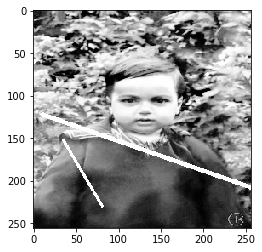

In [15]:
mask = random_mask(256, 256)[:,:,0]
plt.imshow(y_img * mask + (1-mask), cmap = 'gray')

In [206]:
tng_gen, _ = data_batch_generator(masks_train, y_train, \
                                            batch_size = batch_size, seed = seed)

In [207]:
tng_gen

In [ ]:
print('Training starting...')
nb_epoch = 200
n_batches = int(np.ceil(x_train.shape[0] / batch_size))
kernel = np.ones((3,3))
erosion = 0
for epoch in range(1, nb_epoch + 1):
    if epoch > nb_epoch:
        break
    batch_i = 0
    
    
    D_log_loss_a =0
    gen_total_loss_a =0
    gen_mae_a =0
    gen_log_loss_a =0
    
    print('Epoch {}'.format(epoch))
    start = time.time()
    #batch_per_epoch = int(n / batch_size)
    progbar = keras_generic_utils.Progbar(n_batches)
    for masks, imgs in tng_gen:
        if erosion > 0:
            mask_er = cv2.erode(masks[:, :, :, 0].astype('uint8'), kernel=kernel, iterations = erosion)
            mask_er = mask_er[:, :, :, np.newaxis]
        else:
            mask_er = masks
        cond_imgs = imgs * (1 - mask_er) + mask_er
        if batch_i >= n_batches:
            break
        batch_i += 1
        # init the datasources again for each epoch
        #tng_gen = facades_generator(data_dir_name=data_path, data_type='training', im_width=im_width, batch_size=batch_size)
        #val_gen = facades_generator(data_dir_name=data_path, data_type='validation', im_width=im_width, batch_size=batch_size)

            # load a batch of decoded and original images
            # both for training and validation
            #X_train_decoded_imgs, X_train_original_imgs = next(tng_gen)
            #X_val_decoded_imgs, X_val_original_imgs = next(val_gen)

        # generate a batch of data and feed to the discriminator
        # some images that come out of here are real and some are fake
        # X is image patches for each image in the batch
        # Y is a 1x2 vector for each image. (means fake or not)
        #print('x, y for disc')
        X_discriminator, y_discriminator =  patch_utils.get_disc_batch(imgs,#patch_utils.get_disc_batch(imgs,
                                                          cond_imgs,
                                                          generator_nn,
                                                          patch_dim=sub_patch_dim,
                                                          nb_patches = nb_patch_patches)

        # Update the discriminator
        #print('calculating discriminator loss')
        disc_loss = discriminator_nn.train_on_batch([X_discriminator, cond_imgs], y_discriminator)

        # create a batch to feed the generator
        #X_gen_target, X_gen = next(patch_utils.gen_batch(X_train_original_imgs, X_train_decoded_imgs, batch_size))
        y_gen = np.zeros((imgs.shape[0], nb_patch_patches), dtype=np.uint8)

        # Freeze the discriminator
        discriminator_nn.trainable = False

        # trainining GAN
        #print('calculating GAN loss...')
        gen_loss = dc_gan_nn.train_on_batch(cond_imgs, [imgs, y_gen])

        # Unfreeze the discriminator
        discriminator_nn.trainable = True


        # print losses
        D_log_loss = disc_loss
        gen_total_loss = gen_loss[0].tolist()
        gen_total_loss = min(gen_total_loss, 1000000)
        gen_mae = gen_loss[1].tolist()
        gen_mae = min(gen_mae, 1000000)
        gen_log_loss = gen_loss[2].tolist()
        gen_log_loss = min(gen_log_loss, 1000000)
        
        
        D_log_loss_a += D_log_loss/n_batches
        gen_total_loss_a += gen_total_loss/n_batches
        gen_mae_a += gen_mae/n_batches
        gen_log_loss_a += gen_log_loss/n_batches

        progbar.update(batch_i, values=[("Dis logloss", D_log_loss),
                                        ("Gen total", gen_total_loss),
                                        ("Gen L1 (mae)", gen_mae),
                                        ("Gen logloss", gen_log_loss)])
        
        # ---------------------------
        # Save images for visualization every 2nd batch
        #if batch_counter % 2 == 0:

            # print images for training data progress
         #   logger.plot_generated_batch(X_train_original_imgs, X_train_decoded_imgs, generator_nn, epoch, 'tng', mini_batch_i)

            # print images for validation data
          #  X_full_val_batch, X_sketch_val_batch = next(patch_utils.gen_batch(X_val_original_imgs, X_val_decoded_imgs, batch_size))
           # logger.plot_generated_batch(X_full_val_batch, X_sketch_val_batch, generator_nn, epoch, 'val', mini_batch_i)

        # -----------------------
        # log epoch

    D_log_loss_h += [D_log_loss_a]
    gen_total_loss_h += [gen_total_loss_a]
    gen_mae_h +=[gen_mae_a]
    gen_log_loss_h +=[gen_log_loss_a]
    
    if epoch % 300 == 0:
        erosion = max(erosion - 1, 0)
    if epoch % 50 == 0:
        dc_gan_nn.save_weights('../trained_models/patch64_rand.h5')
        with open('../model_data/patch64_rand.pkl', 'wb') as f:
            pickle.dump((D_log_loss_h,gen_total_loss_h, gen_mae_h, gen_log_loss_h), f)
    
    print("")
    print('Epoch %s/%s, Time: %s' % (epoch, nb_epoch, time.time() - start))

    
    #imgs_fake_display = generator_nn.predict(imgs_cond_display, batch_size = n_display)
    #plt.figure(figsize = (10, 50))
    #for i in range(n_display):
    #    plt.subplot(n_display, 3, 3 * i + 1)
    #    plt.imshow(127.5 * (imgs_cond_display[i, :, :, 0] + 1), cmap='gray')
    ##    plt.subplot(n_display, 3, 3 * i + 2)
     #   plt.imshow(127.5 * (imgs_display[i, :, :, 0] + 1), cmap='gray')
     #   plt.subplot(n_display, 3, 3 * i + 3)
     #   plt.imshow(127.5 * (imgs_fake_display[i, :, :, 0] + 1), cmap='gray')
    epoch = epoch + 1

    # ------------------------------
    # save weights on every 2nd epoch
    #if epoch % 2 == 0:
    #    gen_weights_path = os.path.join('./pix2pix_out/weights/gen_weights_epoch_%s.h5' % (epoch))
    #    generator_nn.save_weights(gen_weights_path, overwrite=True)

    #    disc_weights_path = os.path.join('./pix2pix_out/weights/disc_weights_epoch_%s.h5' % (epoch))
    #    discriminator_nn.save_weights(disc_weights_path, overwrite=True)

     #   DCGAN_weights_path = os.path.join('./pix2pix_out/weights/DCGAN_weights_epoch_%s.h5' % (epoch))
     #   dc_gan_nn.save_weights(DCGAN_weights_path, overwrite=True)

Training starting...
Epoch 1
8/8 [==============================] - 17s 2s/step - Dis logloss: 3.1355e-04 - Gen total: 2.2521 - Gen L1 (mae): 0.0224 - Gen logloss: 0.0317

Epoch 1/200, Time: 17.444703578948975
Epoch 2
8/8 [==============================] - 17s 2s/step - Dis logloss: 4.1822e-04 - Gen total: 2.0980 - Gen L1 (mae): 0.0208 - Gen logloss: 0.0849

Epoch 2/200, Time: 17.438528299331665
Epoch 3
8/8 [==============================] - 17s 2s/step - Dis logloss: 0.0012 - Gen total: 2.2175 - Gen L1 (mae): 0.0220 - Gen logloss: 0.0611

Epoch 3/200, Time: 17.431909322738647
Epoch 4
8/8 [==============================] - 17s 2s/step - Dis logloss: 3.3597e-04 - Gen total: 2.1898 - Gen L1 (mae): 0.0217 - Gen logloss: 0.0653

Epoch 4/200, Time: 17.466084718704224
Epoch 5
8/8 [==============================] - 17s 2s/step - Dis logloss: 1.5257e-04 - Gen total: 2.1492 - Gen L1 (mae): 0.0214 - Gen logloss: 0.0534

Epoch 5/200, Time: 17.419843912124634
Epoch 6
8/8 [=========================

In [249]:
epoch

201

In [225]:
cond_imgs = imgs * (1 - mask_er) + mask_er

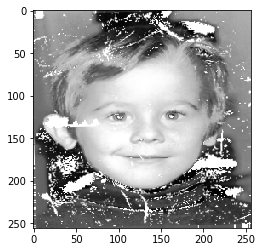

In [227]:
plt.imshow(cond_imgs[2, :, :, 0], cmap = 'gray')
#plt.imshow(mask_er[2, :, :, 0], cmap = 'gray')

In [224]:
np.max(imgs)

1.0

In [124]:
import pickle
with open('../model_data/patch64_rand.pkl', 'wb') as f:
    pickle.dump((D_log_loss_h,gen_total_loss_h, gen_mae_h, gen_log_loss_h), f)

In [123]:
dc_gan_nn.save_weights('../trained_models/patch64_rand_dc_gan.h5')

In [112]:
X_discriminator, y_discriminator =  patch_utils.get_disc_batch(imgs,#patch_utils.get_disc_batch(imgs,
                                                          cond_imgs,
                                                          generator_nn,
                                                          patch_dim=sub_patch_dim,
                                                          nb_patches = nb_patch_patches)

In [193]:
x_test_real.shape

(32, 256, 256, 1)

In [243]:
np.max(x_test_real * 255)

1.0

In [53]:
n_display = 10
imgs = y_test[:n_display, :, :, :]
mask_arr = []
for i in range(imgs.shape[0]):
    mask_arr += [random_mask(im_width, im_height)[:,:,0]]
mask_arr = np.array(mask_arr)
mask_arr = mask_arr.reshape(imgs.shape)
cond_imgs = imgs * mask_arr + (1 - mask_arr)
imgs_fake = generator_nn.predict(x_test_real[:n_display, :, :, :])
imgs_fake2 = generator_nn.predict(cond_imgs)
plt.close('all')
plt.figure(figsize = (40, 50))
for i in range(n_display):
    plt.subplot(n_display, 5, 1 + 5 * i)
    cv2.imwrite('../model_data/images_final/test/' + str(i) + '_damaged.png', 
                cv2.cvtColor((255 * x_test_real[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(x_test_real[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 2 + 5 * i)
    cv2.imwrite('../model_data/images_final/test/' + str(i) + '_original.png', 
                cv2.cvtColor((255 * y_test[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(y_test[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 3 + 5 * i)
    cv2.imwrite('../model_data/images_final/test/' + str(i) + '_generated.png', 
                cv2.cvtColor((255 * imgs_fake[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs_fake[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 4 + 5 * i)
    cv2.imwrite('../model_data/images_final/test/' + str(i) + '_generated2.png', 
                cv2.cvtColor((255 * imgs_fake2[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs_fake2[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 5 + 5 * i)
    cv2.imwrite('../model_data/images_final/test/' + str(i) + '_damaged2.png', 
                cv2.cvtColor((255 * cond_imgs[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(cond_imgs[i, :, :, 0], cmap = 'gray')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [52]:
np.min(imgs_fake)

-1.0000001

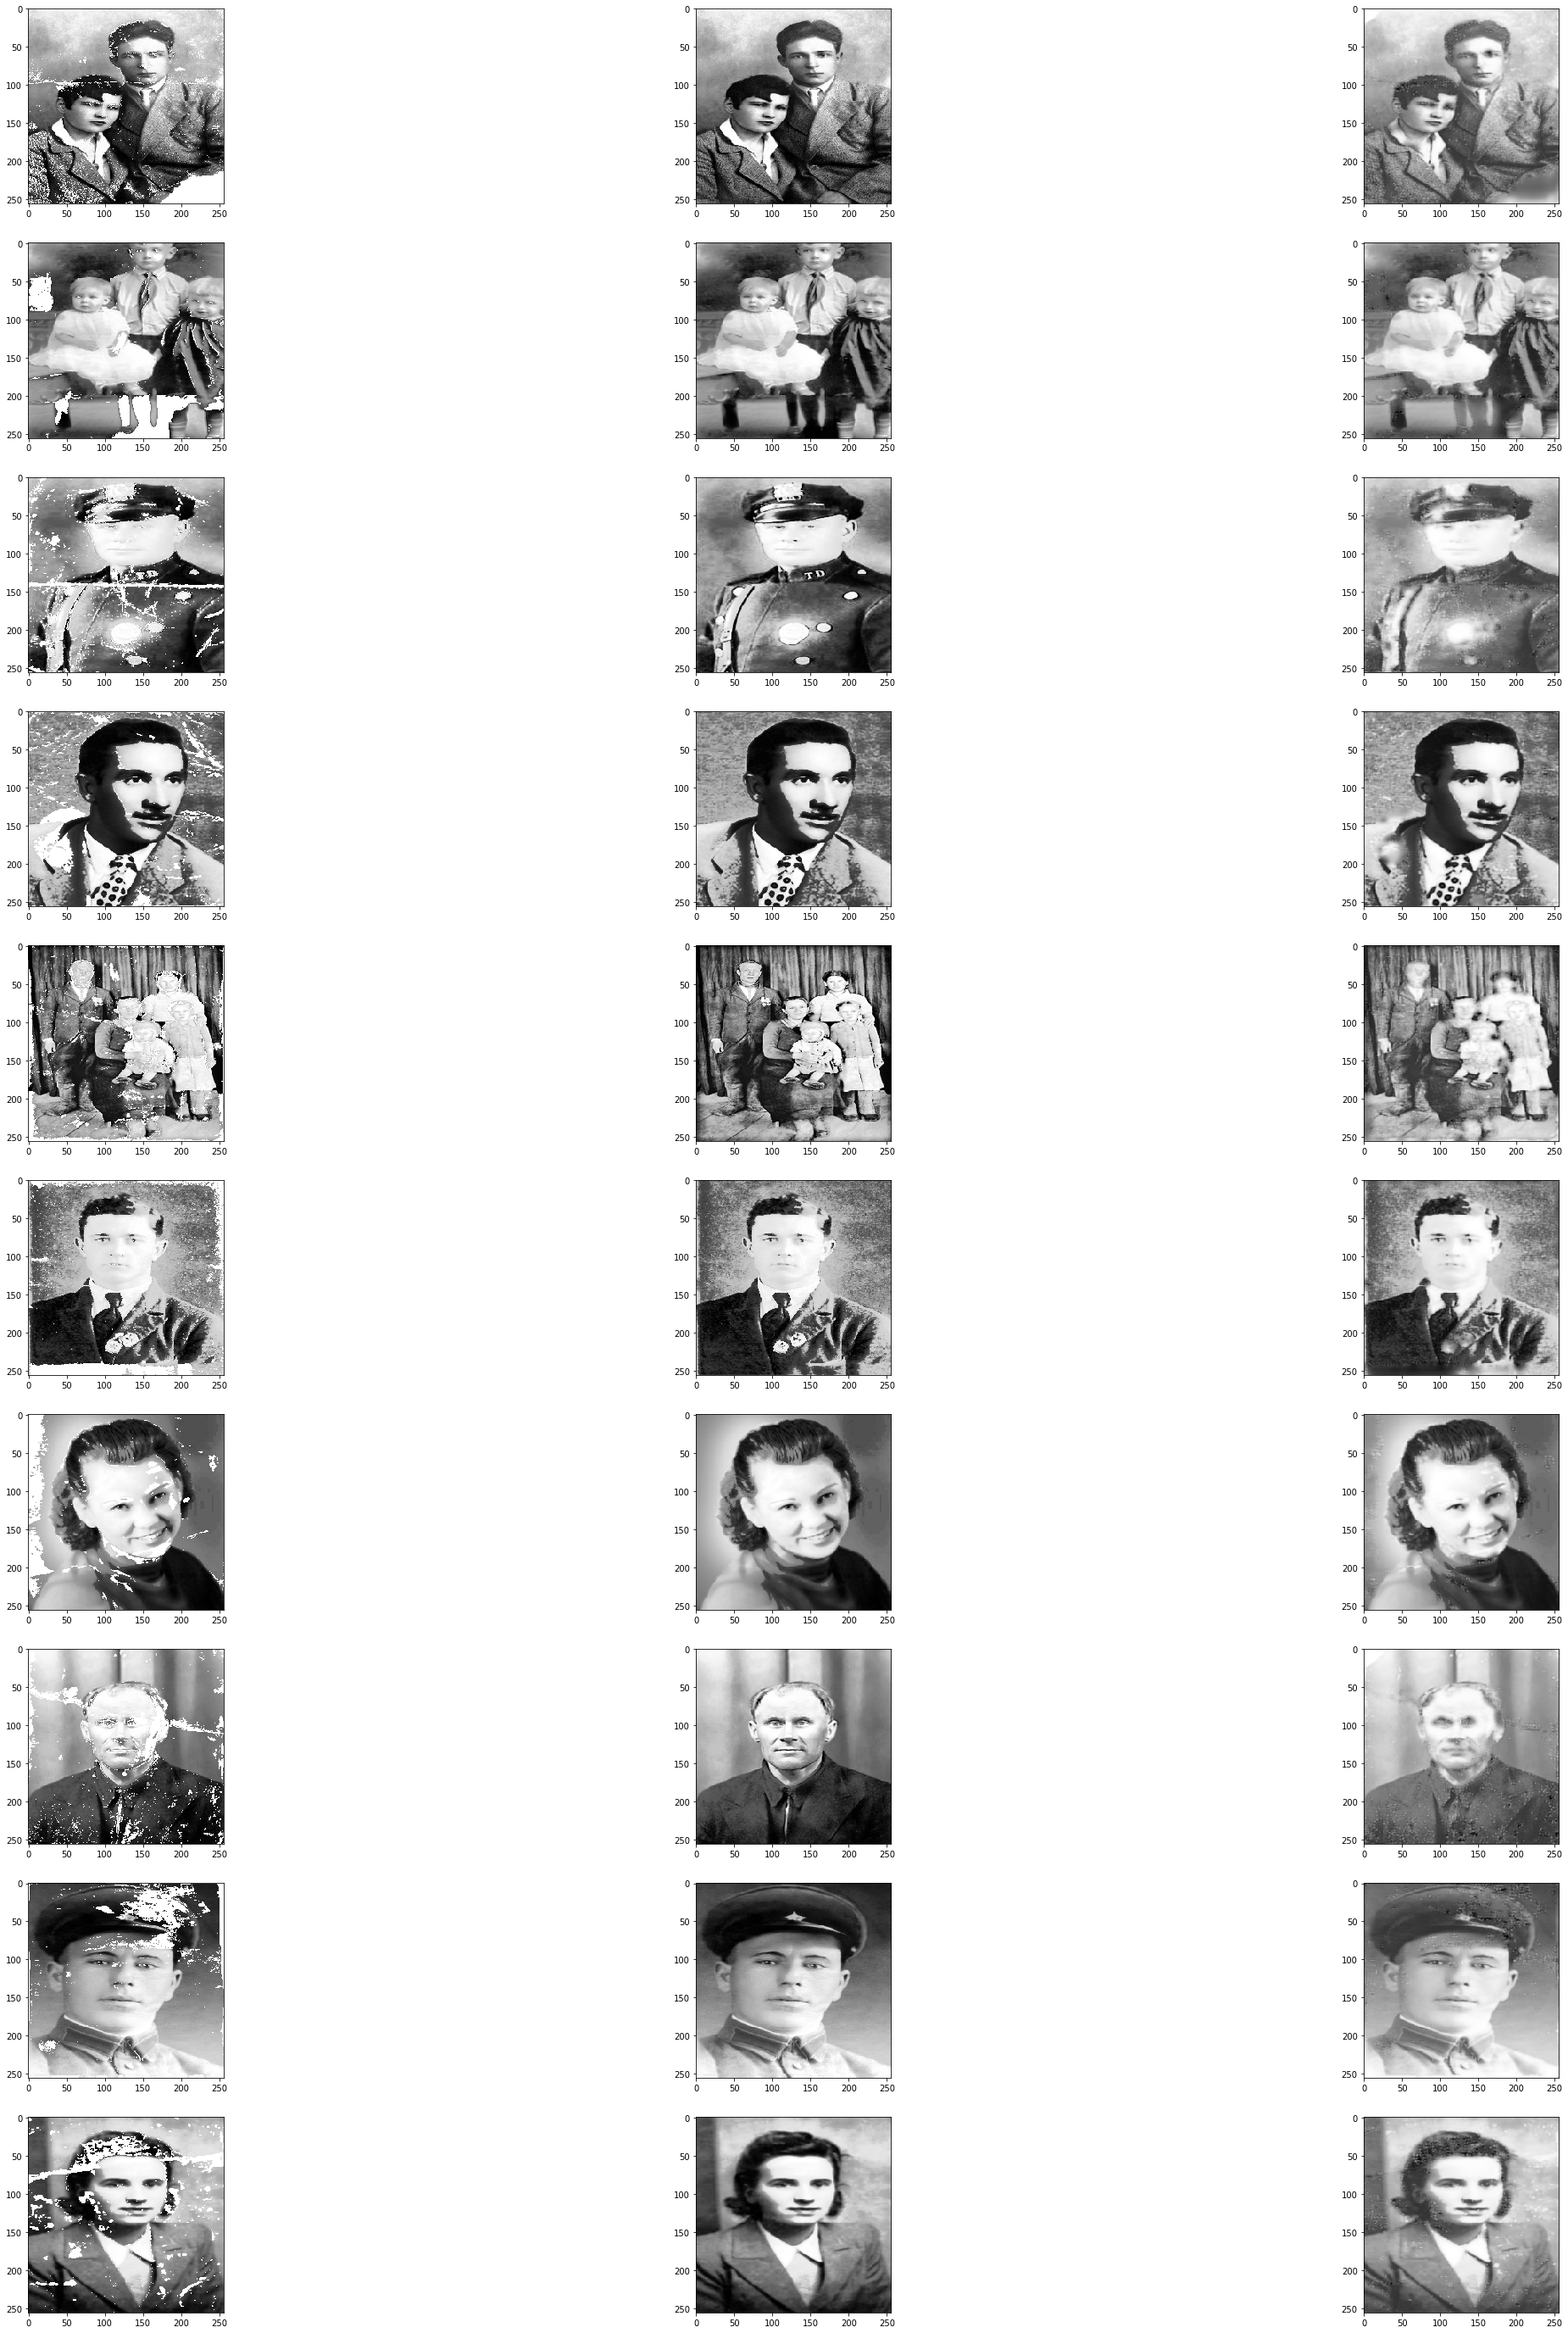

In [54]:
n_display = 10
imgs = y_train[:n_display, :, :, :]
masks = masks_train[:n_display, :, :, :]
cond_imgs = imgs * (1 - masks) + masks
imgs_fake = generator_nn.predict(cond_imgs)
plt.close('all')
plt.figure(figsize = (40, 50))
for i in range(n_display):
    plt.subplot(n_display, 3, 1 + 3 * i)
    cv2.imwrite('../model_data/images_final/train/' + str(i) + '_damaged.png', 
                cv2.cvtColor((255 * x_train[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(cond_imgs[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 2 + 3 * i)
    cv2.imwrite('../model_data/images_final/train/' + str(i) + '_original.png', 
                cv2.cvtColor((255 * y_train[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 3 + 3 * i)
    cv2.imwrite('../model_data/images_final/train/' + str(i) + '_generated.png', 
                cv2.cvtColor((255 * imgs_fake[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs_fake[i, :, :, 0], cmap = 'gray')

In [85]:
plt.rcParams['font.size'] = 20

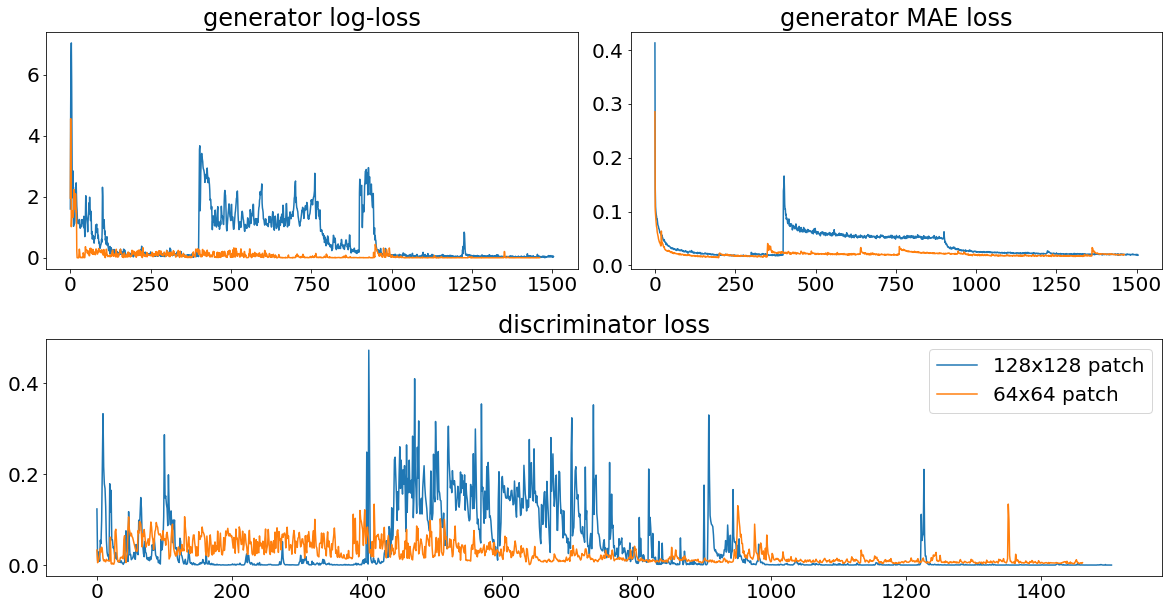

In [99]:
plt.figure(figsize = (20, 10))
grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.3)
plt.subplot(grid[0, 0])
#plt.subplot(3, 1, 1)
plt.title('generator log-loss')
plt.plot(gen_log_loss_h)
plt.plot(gen_log_loss_h2)

plt.subplot(grid[0, 1])
#plt.subplot(3, 1, 2)
plt.title('generator MAE loss')
plt.plot(gen_mae_h)
plt.plot(gen_mae_h2)
plt.subplot(grid[1, :])
#plt.subplot(3, 1, 3)
plt.title('discriminator loss')
plt.plot(D_log_loss_h)
plt.plot(D_log_loss_h2)
plt.legend(['128x128 patch', '64x64 patch'])
plt.savefig('Losses_pix2pix.png')
plt.show()

In [68]:
len(D_log_loss_h2)

350

In [75]:
with open('../model_data/patch64_rand.pkl', 'rb') as f:
    D_log_loss_h,gen_total_loss_h, gen_mae_h, gen_log_loss_h = pickle.load(f)
with open('../../64x64gan/model_data64/patch64_rand.pkl', 'rb') as f:
    D_log_loss_h2,gen_total_loss_h2, gen_mae_h2, gen_log_loss_h2 = pickle.load(f)

[1 1 1 1]


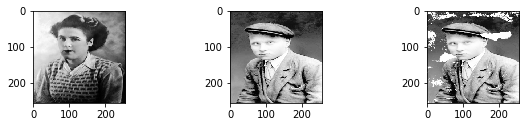

[0 0 0 0]


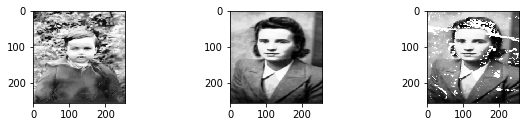

[1 1 1 1]


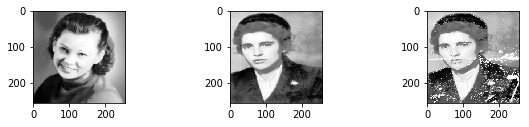

[1 1 1 1]


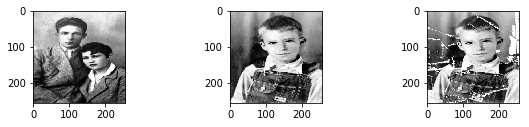

[1 1 1 1]


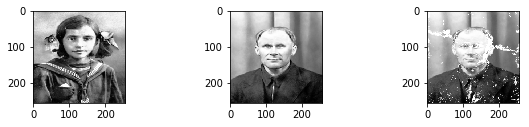

[1 1 1 1]


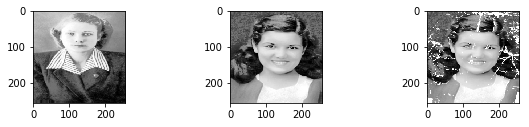

[0 0 0 0]


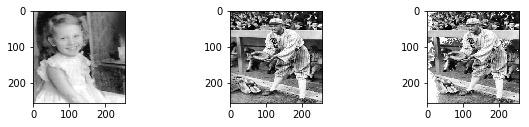

[1 1 1 1]


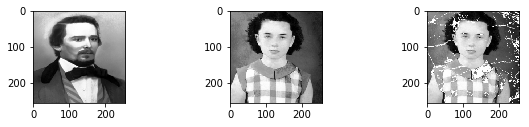

In [239]:
n_display = 10
imgs_fake = generator_nn.predict(x_train[:n_display, :, :, :])
plt.close('all')
plt.figure(figsize = (3, 5))
for i in range(8):
    print(y_discriminator[i, :])
    plt.figure(figsize = (10, 20))
    plt.subplot(n_display, 3, 1 + 3 * i)
    plt.imshow(X_discriminator[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 2 + 3 * i)
    plt.imshow(imgs[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 3 + 3 * i)
    plt.imshow(cond_imgs[i, :, :, 0], cmap = 'gray')
    plt.show()

In [40]:
y_discriminator.shape

(8, 16)

In [27]:
idx2name = {}
name2idx = {}
for i in range(n):
    im = cv2.cvtColor(cv2.imread(DATASET[1] + str(i) + '.png'), cv2.COLOR_RGB2GRAY)
    for j in range(y_test.shape[0]):
        if np.linalg.norm(im/255 - y_test[j, :, :, 0]) < 0.001:
            idx2name[i] = j
            name2idx[j] = i

In [28]:
idx2name_tr = {}
name2idx_tr = {}
for i in range(n):
    im = cv2.cvtColor(cv2.imread(DATASET[1] + str(i) + '.png'), cv2.COLOR_RGB2GRAY)
    for j in range(y_train.shape[0]):
        if np.linalg.norm(im/255 - y_train[j, :, :, 0]) < 0.001:
            idx2name_tr[i] = j
            name2idx_tr[j] = i

In [29]:
idx2name.keys()

dict_keys([5, 11, 14, 16, 19, 29, 31, 35, 40, 42, 51, 53, 58, 59, 73, 78, 81, 88, 91, 92, 94, 95, 100, 107, 108, 118, 120, 124, 126, 143, 145, 156])

In [59]:
idx2name.keys()

dict_keys([5, 11, 14, 16, 19, 29, 31, 35, 40, 42, 51, 53, 58, 59, 73, 78, 81, 88, 91, 92, 94, 95, 100, 107, 108, 118, 120, 124, 126, 143, 145, 156])

In [62]:
name2idx.keys()

dict_keys([23, 7, 2, 26, 5, 0, 25, 21, 8, 16, 18, 17, 14, 20, 6, 27, 3, 15, 29, 11, 13, 9, 10, 1, 12, 28, 30, 4, 24, 22, 19, 31])

In [43]:
masks_test = []
x_test_real = []
for i in range(y_test.shape[0]):
    mask = cv2.cvtColor(cv2.imread(DATASET[0] + str(name2idx[i]) + '.png'), cv2.COLOR_RGB2GRAY)
    x_test_real += [mask/255]
    mask = 1 * (mask == 255)
    masks_test+= [mask]

In [44]:
masks_train = []
x_train_real = []
for i in range(y_train.shape[0]):
    mask = cv2.cvtColor(cv2.imread(DATASET[0] + str(name2idx_tr[i]) + '.png'), cv2.COLOR_RGB2GRAY)
    x_train_real += [mask / 255]
    mask = 1 * (mask == 255)
    masks_train+= [mask]

In [45]:
masks_test = np.array(masks_test)[:,:,:,np.newaxis]

In [46]:
masks_train = np.array(masks_train)[:,:,:,np.newaxis]

In [47]:
x_test_real = np.array(x_test_real)[:, :, :, np.newaxis]

In [48]:
x_train_real = np.array(x_train_real)[:, :, :, np.newaxis]

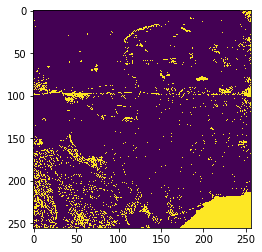

In [201]:
kernel = np.ones((3, 3))
plt.imshow(eroded[0,:, :])
plt.show()

In [172]:
name2idx_tr[0]

135

In [200]:
eroded = cv2.erode(masks_train[:,:, :, 0].astype('uint8'), kernel=kernel, iterations = 0)